# Libraries

**Elasticsearch Query**

In [1]:
import sys
pathModulesES = '../sauceforyall/'
sys.path.append(pathModulesES)

In [2]:
from yelpquery import YelpQuery
from pandasticsearch import Select
ye = YelpQuery()

**Machine Learning**

In [3]:
import pandas as pd
import numpy as np
import nltk
import pickle

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

**Visualize**

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Others**

In [6]:
import re
import string

**Index name**

In [7]:
index_business = "yelp-business*"
index_review = "yelp-review*"
index_tip = "yelp-tip*"
index_user = "yelp-user*"

In [8]:
data_path = "/home/hongphuc95/notebookteam/dataset/"

# 1. Data Pre-Processing

## 1.1 Load and clean data

In [9]:
df = pd.read_json(data_path + "cleaned/restaurant_review_cleaned_2018_AZ.json", lines=True)

**Missing data**

In [10]:
df.isna().any()

business_id       False
name              False
categories        False
city              False
business_stars    False
cool               True
useful             True
funny              True
stars              True
review_id          True
user_id            True
date               True
text               True
dtype: bool

In [11]:
df = df.dropna(subset=["review_id"])

In [12]:
df.shape

(205825, 13)

**Get relevant data for the recommandation**

In [13]:
relevant_feature = ["business_id", "user_id", "stars"]
recommender_df = df[relevant_feature]

In [14]:
recommender_df.head()

,business_id,user_id,stars
0,C2wtzldZi02IwFSp8zgT0w,vwi68eg4bmJHMSYq3jP2OQ,4.0
1,rPY4bukI1QdfJc-1OCAwLg,Dlq7uM4eg2tYXX22MUjYlQ,5.0
2,rPY4bukI1QdfJc-1OCAwLg,NNXx0ccFbBLykwbmq9uqMQ,1.0
3,rPY4bukI1QdfJc-1OCAwLg,2BF4W15wdzpaQQUKFsQe9Q,5.0
4,rPY4bukI1QdfJc-1OCAwLg,XIWbu1y3MoqtdPqdglNUEg,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8131cb1c50>]],
      dtype=object)

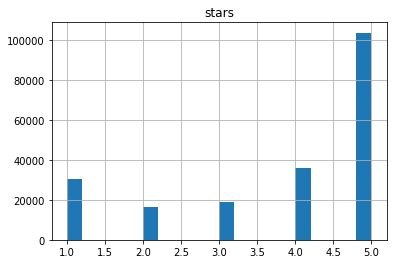

In [15]:
recommender_df.hist(bins=20)

In [16]:
review_count_df = recommender_df.groupby("user_id")["stars"].count()

In [17]:
#review_count_df[review_count_df >= 10].reset_index()[["user_id"]]

In [18]:
review_count_df.describe()

count    98621.000000
mean         2.087030
std          3.498437
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        156.000000
Name: stars, dtype: float64

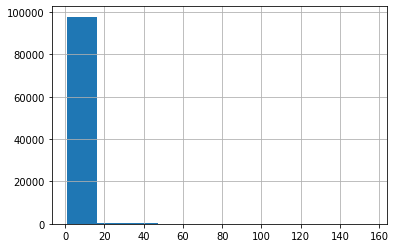

In [19]:
review_count_df.hist(bins=10)

**Filter active user whose has more than 10 reviews**

In [20]:
filter_active_user = []
for user in review_count_df[review_count_df >= 10].index:
    filter_active_user.append(user)

In [21]:
active_user_df = recommender_df[recommender_df["user_id"].isin(filter_active_user)]

In [22]:
index_dup = active_user_df[active_user_df.duplicated(["business_id", "user_id"])].index

In [23]:
active_user_df = active_user_df.drop(index_dup, axis=0)

In [24]:
user_id = list(set(active_user_df['user_id']))
business_id = list(set(active_user_df['business_id']))

In [25]:
def create_user_id_matrix(row, user_id):
    return user_id.index(row["user_id"])

def create_business_id_matrix(row, business_id):
    return business_id.index(row["business_id"])

In [26]:
active_user_df["user_id_matrix"] = active_user_df.apply(lambda x: create_user_id_matrix(x, user_id), axis = 1)

In [27]:
active_user_df["business_id_matrix"] = active_user_df.apply(lambda x: create_business_id_matrix(x, business_id), axis = 1)

In [28]:
active_user_df

,business_id,user_id,stars,user_id_matrix,business_id_matrix
0,C2wtzldZi02IwFSp8zgT0w,vwi68eg4bmJHMSYq3jP2OQ,4.0,2087,5330
4,rPY4bukI1QdfJc-1OCAwLg,XIWbu1y3MoqtdPqdglNUEg,1.0,9,337
46,AsKb-lUO_3MYFg6df9QTsw,3XYdH4xBZjftw8cbWUTjSg,3.0,731,1611
69,X92XkmKWt5TjNiD2m6tadg,eD4NNh2L1EBwYZiHlsiSAg,1.0,1477,2208
70,X92XkmKWt5TjNiD2m6tadg,GCDf7UWiDfyg2JenNuYgZQ,1.0,570,2208
...,...,...,...,...,...
209550,_-OJ4-bPGyKQ9Hcc5JeSqw,j4KaTVeOxUyIRjdRO3vl0Q,4.0,1303,3405
209552,_-OJ4-bPGyKQ9Hcc5JeSqw,OvYN86BmZyP87SaTO7mHkQ,4.0,671,3405
209553,In1B_y225-bJw3jfbk1uAA,98F1MRVrJP4WefdFTIVjTA,5.0,266,477
209556,In1B_y225-bJw3jfbk1uAA,ZUnmsVs1Vdp9_UtG41u7mw,5.0,1031,477


In [31]:
r_df = active_user_df.pivot(index="user_id", columns="business_id", values="stars").fillna(0)

In [32]:
r_df

business_id,-01XupAWZEXbdNbxNg5mEg,-092wE7j5HZOogMLAh40zA,-0WegMt6Cy966qlDKhu6jA,-0tgMGl7D9B10YjSN2ujLA,-1UMR00eXtwaeh59pEiDjA,-1VaIJza42Hjev6ukacCNg,-45kMvS7h38CGaWugPY0rg,-4TMQnQJW1yd6NqGRDvAeA,-6h3K1hj0d4DRcZNUtHDuw,-6tvduBzjLI1ISfs3F_qTg,...,ztcdHj6EpUD7EemcntSsrg,zuVvDYJkKAbXQTTBauAqJQ,zusXbyXnJfS1Q-pZE9elmQ,zvB0Vzhomsodw_iQ7FHY1Q,zwNLJ2VglfEvGu7DDZjJ4g,zwmps5SXn30g-f5wqg_r9A,zy6Hzao6lTmuJMZo4BemIg,zyPGYeXF4XKCqNN1pjFWhg,zzsOLFhgUw8gnjLTVVItFA,zzwicjPC9g246MK2M1ZFBA
user_id,,,,,,,,,,,,,,,,,,,,,
--2HUmLkcNHZp0xw6AMBPg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--Nnm_506G_p8MxAOQna5w,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1ZMRA0N01rqZL0TWk3fgA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7QXB6HDjutUk1nVazWU4Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8rSnT5ztVk6vmTDkxTqsQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zrgjucUkCgNPWvqwZGvvLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ztMTJcpz68xTn154D86Iww,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zx3y74_pvIRuQSVIrgzCew,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
for i in r_df.loc["--Nnm_506G_p8MxAOQna5w"]:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


## 1.2 Create sparse matrix from records

In [29]:
from scipy import sparse

In [30]:
highest_user_id = len(active_user_df['user_id'].unique())
highest_business_id = len(active_user_df['business_id'].unique())
shape_matrix = (highest_user_id, highest_business_id)
ratings_mat = sparse.lil_matrix(shape_matrix)

In [31]:
ratings_mat

<2203x6075 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in List of Lists format>

In [32]:
for i, row in active_user_df.iterrows():
    ratings_mat[row["user_id_matrix"], row["business_id_matrix"]] = row["stars"]

In [33]:
ratings_mat

<2203x6075 sparse matrix of type '<class 'numpy.float64'>'
	with 40037 stored elements in List of Lists format>

# 2. NMF Implementation

In [34]:
from time import time

In [35]:
from sklearn.decomposition import NMF
class NMF_Recommender(object):

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, ratings_mat):
        self.ratings_mat = ratings_mat
        self.n_users = ratings_mat.shape[0]
        self.n_items = ratings_mat.shape[1]
        
        nmf = NMF(n_components = 200)
        nmf.fit(ratings_mat)
        
        #Features
        self.W = nmf.transform(ratings_mat)
        
        #Features Weight
        self.H = nmf.components_
        
        #Reconstructed matrix
        self.ratings_mat_fitted = self.W.dot(self.H)
        self.error = nmf.reconstruction_err_
        

    def get_error(self):
        return self.error
        
    def pred_one_user(self, user_id, report_run_time=False):
        start_time = time()
        cleaned_out = self.ratings_mat_fitted[user_id,:]
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        return cleaned_out

    def pred_all_users(self, report_run_time=False):
        start_time = time()
        all_ratings = [
            self.pred_one_user(user_id) for user_id in range(self.n_users)
        ]
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        return np.array(all_ratings)

    def top_n_recs(self, user_id, n):
        pred_ratings = self.pred_one_user(user_id)
        item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1]
        unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                        if item not in items_rated_by_this_user]
        return unrated_items_by_pred_rating[-n:], items_rated_by_this_user

In [39]:
lucky_user = np.random.choice(active_user_df['user_id'], 1)[0]
lucky_user_index = user_id.index(lucky_user)

In [40]:
# get recommendations for the same lucky user
my_rec_engine = NMF_Recommender(n_components=200)
my_rec_engine.fit(ratings_mat)
lucky_user_recommend, items_rated_by_this_user = my_rec_engine.top_n_recs(user_id=lucky_user_index, n = 10)

In [42]:
print("The top ten recommendation for user %s are: " % (lucky_user))
print('%s' % (', '.join(list(set(df['name'][df['business_id'] == business_id[i]]))[0] \
                       for i in lucky_user_recommend)))

The top ten recommendation for user IZnsvdPqU_LWTy4yfgiX4A are: 
S & V Urban Italian, Breakfast Club- Scottsdale, Durant's, Seasons 52, Nirvana Indian Cuisine, Iron Chef, Farmboy Market, Meats, Sandwiches, Yo Pauly's NY Pizza, Cheddar's Scratch Kitchen, Local Bistro


In [44]:
print("The users original rated resturants are :\n %s" % (','.join(list(set(df['name'][df['business_id'] == business_id[i]]))[0] \
                       for i in items_rated_by_this_user)))

The users original rated resturants are :
 RnR Gastropub,St. Francis Restaurant,Asi Es La Vida,Tee Pee Mexican Food,Hash Kitchen,Hula's Modern Tiki Scottsdale,Beverly on Main,Pizza Hut,Beckett's Table,Eddie V's Prime Seafood,Thirsty Lion Gastropub & Grill,Bobby Q,Frank & Albert's,Snooze, An A.M. Eatery,First Watch,Canton Dragon Asian Grill And Bar,First Watch,Manuel's Mexican Restaurant & Cantina,Mastro's City Hall,Delux,Fleming's Prime Steakhouse - Scottsdale,Ladera Taverna y Cocina,Dominick's Steakhouse,Bandera,Fajitas A Sizzlin Celebration,Geordie's Steak,Olive & Ivy,Blue Clover Distillery,The Vig Uptown,Daily Dose Midtown,T Cook's,Zipps Sports Grill,The Herb Box,Chino Bandido,Mastro's Steakhouse,Haus Murphy's,Dick's Hideaway,Second Story Restaurant & Liquor Bar,Mastro's Ocean Club,The Haymaker Restaurant,Compass Arizona Grill


In [45]:
my_rec_engine.get_error()

674.6410728193946

# 3. SVD Truncated Implemenatation

In [33]:
filter_business = [business in business_id for business in df_review['business_id']]
category = df_review['categories'][filter_business]

In [34]:
for i, cat in category.iteritems():
    category[i] = ",".join(cat)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = 'english', 
                             lowercase = True
                            )
category_vec = vectorizer.fit_transform(category).toarray()
words = vectorizer.get_feature_names()
#This is the number of unique categories
print('The total number of restaurant categories is %d' % (len(words)))

The total number of restaurant categories is 464


In [37]:
words

['acai',
 'accessories',
 'active',
 'activities',
 'adoption',
 'adult',
 'afghan',
 'african',
 'airports',
 'amateur',
 'american',
 'amusement',
 'animal',
 'antiques',
 'appliances',
 'arabian',
 'arcades',
 'arenas',
 'argentine',
 'armenian',
 'art',
 'arts',
 'asian',
 'australian',
 'austrian',
 'automotive',
 'bagels',
 'bakeries',
 'bar',
 'barbeque',
 'barbers',
 'bars',
 'bartenders',
 'basque',
 'bath',
 'beauty',
 'beds',
 'beer',
 'belgian',
 'belt',
 'beverage',
 'bikes',
 'bistros',
 'blues',
 'books',
 'bookstores',
 'botanical',
 'bounce',
 'bowling',
 'bowls',
 'brasseries',
 'brazilian',
 'breakfast',
 'breweries',
 'brewpubs',
 'british',
 'brunch',
 'bubble',
 'buffets',
 'building',
 'burgers',
 'butcher',
 'cafes',
 'cafeteria',
 'cajun',
 'cake',
 'cakes',
 'cambodian',
 'candy',
 'cantonese',
 'car',
 'cardiologists',
 'caribbean',
 'cashing',
 'casinos',
 'caterers',
 'center',
 'centers',
 'champagne',
 'chapels',
 'check',
 'cheese',
 'cheesesteaks',
 'ch

In [89]:
from sklearn.decomposition import TruncatedSVD
class SVD_Recommender(object):

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, ratings_mat):
        self.ratings_mat = ratings_mat
        self.n_users = ratings_mat.shape[0]
        self.n_items = ratings_mat.shape[1]
        
        #the size of the single value is n_components
        svd = TruncatedSVD(n_components=self.n_components, n_iter=7, random_state=1)
        svd.fit(ratings_mat)
        self.V = svd.components_
        self.U = svd.transform(ratings_mat)
        self.ratings_mat_fitted = self.U.dot(self.V)

    def get_error(self):
        return ((self.ratings_mat_fitted - self.ratings_mat)**2).mean(axis=None)
        
    def pred_one_user(self, user_id, report_run_time=False):
        start_time = time()
        cleaned_out = self.ratings_mat_fitted[user_id,:]
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        return cleaned_out

    def pred_all_users(self, report_run_time=False):
        start_time = time()
        all_ratings = [
            self.pred_one_user(user_id) for user_id in range(self.n_users)]
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        return np.array(all_ratings)

    def top_n_recs(self, user_id, n):
        pred_ratings = self.pred_one_user(user_id)
        item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1]
        unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                        if item not in items_rated_by_this_user]
        return unrated_items_by_pred_rating[-n:], items_rated_by_this_user

In [90]:
my_rec_engine = SVD_Recommender(n_components=len(words))
my_rec_engine.fit(ratings_mat)

In [92]:
lucky_user_recommend, items_rated_by_this_user = my_rec_engine.top_n_recs(user_id=lucky_user_index, n = 10)
print("The top ten recommendation for user %s are: " % (lucky_user))
print('%s' % (', '.join(list(set(df_review['name'][df_review['business_id'] == business_id[i]]))[0] \
                       for i in lucky_user_recommend)))

The top ten recommendation for user iuz4lXjzwaxuFWaLqUl6gA are: 
Tea Swirl, Julio's Too, Curry Corner, Naked BBQ, The Cheesecake Factory, Houston's Restaurant, Paul Martin's American Grill, The Montauk, Sweet Kicks, Chula Seafood


# 4. Item-Item

In [91]:
from sklearn.metrics.pairwise import cosine_similarity
from time import time
class ItemItemRecommender(object):

    def __init__(self, neighborhood_size):
        self.neighborhood_size = neighborhood_size

    def fit(self, ratings_mat):
        self.ratings_mat = ratings_mat
        self.n_users = ratings_mat.shape[0]
        self.n_items = ratings_mat.shape[1]
        self.item_sim_mat = cosine_similarity(self.ratings_mat.T)
        self._set_neighborhoods()

    def _set_neighborhoods(self):
        least_to_most_sim_indexes = np.argsort(self.item_sim_mat, 1)
        self.neighborhoods = least_to_most_sim_indexes[:, -self.neighborhood_size:]

    def pred_one_user(self, user_id, report_run_time=False):
        start_time = time()
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1]
        # Just initializing so I have somewhere to put rating preds
        out = np.zeros(self.n_items)
        for item_to_rate in range(self.n_items):
            relevant_items = np.intersect1d(self.neighborhoods[item_to_rate],
                                            items_rated_by_this_user,
                                            assume_unique=True)  # assume_unique speeds up intersection op
            out[item_to_rate] = self.ratings_mat[user_id, relevant_items] * \
                self.item_sim_mat[item_to_rate, relevant_items] / \
                self.item_sim_mat[item_to_rate, relevant_items].sum()
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        cleaned_out = np.nan_to_num(out)
        return cleaned_out

    def pred_all_users(self, report_run_time=False):
        start_time = time()
        all_ratings = [
            self.pred_one_user(user_id) for user_id in range(self.n_users)]
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        return np.array(all_ratings)

    def top_n_recs(self, user_id, n):
        pred_ratings = self.pred_one_user(user_id)
        item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1]
        unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                        if item not in items_rated_by_this_user]
        return unrated_items_by_pred_rating[-n:], items_rated_by_this_user

In [92]:
my_rec_engine = ItemItemRecommender(neighborhood_size=80)
my_rec_engine.fit(ratings_mat)

In [93]:
lucky_user = np.random.choice(active_user_df['user_id'], 1)[0]
lucky_user_index = user_id.index(lucky_user)
lucky_user_recommend, items_rated_by_this_user = my_rec_engine.top_n_recs(user_id=lucky_user_index, n = 10)

/home/hongphuc95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [95]:
print("The top ten recommendation for user %s are: " % (lucky_user))
print('%s' % (', '.join(list(set(df_review['name'][df_review['business_id'] == business_id[i]]))[0] \
                       for i in lucky_user_recommend)))

The top ten recommendation for user 0NNpVwcs7XEs-rLAreUN3w are: 
KFC, Brigett's Last Laugh, Thai Plates Cuisine, Filiberto's Mexican Food, Whataburger, Toyama, Dairy Queen, Sonic Drive-In, Starbucks, Midwestern Meats
